# Read text to dataframe

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [18]:
def readfile (path, filename):
    f = open(path + filename, "r")
    txt = f.read().splitlines()

    flag = False
    content = ""
    try:
        label = filename.split("_")[0]
        _id = filename.split("_")[2].split('.')[0]
    except:
        label = 0
        _id = filename.split("_")[1].split('.')[0]

    for line in txt:
        if line[-1:] == ":" : 
            flag = True
            continue
        if flag:
            content += (" " + line)
            
    return (content, label, _id)

def files_to_df(path, files):
    df = pd.DataFrame(columns = ["content", "label", "id"])
    for file in files:
        content, label, _id = readfile(path, file)
        df = df.append({
            "content": content,
            "label": label,
            "id": _id

        }, ignore_index=True)
    return df

In [19]:
traning_files = listdir("./data/Training data/")
testing_files = listdir("./data/Testing data/")
df = files_to_df("./data/Training data/", traning_files)
df_test = files_to_df("./data/Testing data/", testing_files)
# df.to_csv("./data/traning_data.csv", index=False)
# df_test.to_csv("./data/testing_data.csv", index=False)

# Text Processing

In [20]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer, PorterStemmer

# nltk.download("stopwords")
# nltk.download('punkt')
# nltk.download('wordnet')

# stopwords setting
stopwords = set(stopwords.words('english'))
symbols   = ['.', ',', '’', '“', '”', '"', "''",
             "'", '*', '``', '**', '$', '%', '&', '#',
             '-', '--', "''", '""', '?', '!', ':', ';',
             '(', ')', '[', ']', '{', '}', "/"]
stopwords.update(symbols)


# tokenize, lemmatize, stemming, filter with stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
clean_content = []

for i in range(0, len(df["content"])):
    content = df["content"][i]
    word_list = word_tokenize(content.lower())
    lemmatizer_stemming_content = " ".join(
        stemmer.stem(lemmatizer.lemmatize(word)) for word in word_list if word not in stopwords
    )
    clean_content.append(lemmatizer_stemming_content)
    
df = df.assign(clean_content = clean_content)

clean_content = []

for i in range(0, len(df_test["content"])):
    content = df_test["content"][i]
    word_list = word_tokenize(content.lower())
    lemmatizer_stemming_content = " ".join(
        stemmer.stem(lemmatizer.lemmatize(word)) for word in word_list if word not in stopwords
    )
    clean_content.append(lemmatizer_stemming_content)

df_test = df_test.assign(clean_content = clean_content)


## Freq words

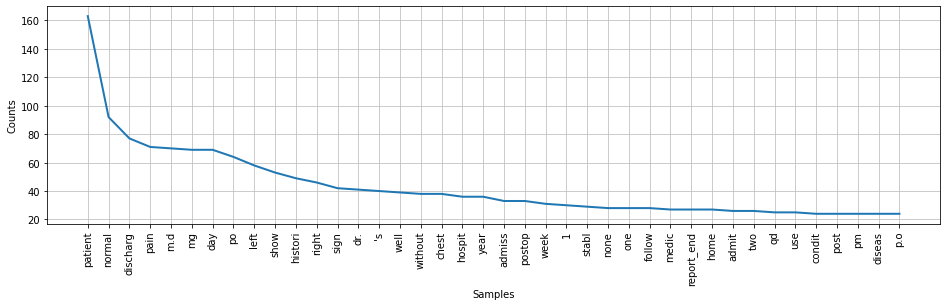

In [21]:
all_words = []
processed = df["clean_content"]
for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

# show all words freq
fdist_content = nltk.FreqDist(all_words)
plt.figure(figsize=(16,4))
fdist_content.plot(40,cumulative=False)

## Training, Testing

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.classify import SklearnClassifier

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

def find_features(content):
    words = word_tokenize(content)
    features = {}
    for word in word_features:
        features[word] = (word in words)
    return features

In [78]:
# label Y
encoder = LabelEncoder()
Y = encoder.fit_transform(df["label"])

# assign X
X = list(df["clean_content"])
X_testing = list(df_test["clean_content"])

# word features
word_features = ["smoke", "smoker", "tobacco", "addict", "drug", "cancer", "lung"]
content_list = list(zip(X, Y))

seed = 0
np.random.seed = seed
np.random.shuffle(content_list)

# call find_features function for each SMS message
featuresets = [(find_features(text), label) for (text, label) in content_list]

# split data to training, testing
training, testing = model_selection.train_test_split(featuresets, test_size = 0.33, random_state = seed)

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing) * 100
    print("{} Accuracy: {}".format(name, accuracy))

K Nearest Neighbors Accuracy: 64.28571428571429
Decision Tree Accuracy: 64.28571428571429
Random Forest Accuracy: 57.14285714285714
Logistic Regression Accuracy: 71.42857142857143
SGD Classifier Accuracy: 57.14285714285714
Naive Bayes Accuracy: 35.714285714285715
SVM Linear Accuracy: 71.42857142857143


# TF-IDF

In [99]:
# need survey how does TF-IDF work, not yet done
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

df_x = df["clean_content"]
df_y = Y
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_x, df_y, test_size = 0.3)

tfidf_cv = TfidfVectorizer(min_df = 1, max_df = 1, ngram_range = (1, 2), stop_words = "english")
x_traincv = tfidf_cv.fit_transform(x_train)
x_testcv = tfidf_cv.transform(x_test)

mnb = MultinomialNB()
y_train=y_train.astype('int')
mnb.fit(x_traincv, y_train)

predictions = mnb.predict(x_testcv)
actual = np.array(y_test)

In [100]:
count = 0
for i in range(len(predictions)):
    if predictions[i] == actual[i]:
        count += 1
accuracy = count / float(len(predictions))
print("Accuracy: {}".format(accuracy))

Accuracy: 0.4166666666666667


## Confusion matrix

/Library/Python/3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

Current Smoker       0.25      1.00      0.40         2
        Smoker       0.67      0.67      0.67         3
    Non-Smoker       0.00      0.00      0.00         3
       Unknown       1.00      0.25      0.40         4

      accuracy                           0.42        12
     macro avg       0.48      0.48      0.37        12
  weighted avg       0.54      0.42      0.37        12

**************************************************************
Normalized confusion matrix
[[1.         0.         0.         0.        ]
 [0.33333333 0.66666667 0.         0.        ]
 [0.66666667 0.33333333 0.         0.        ]
 [0.75       0.         0.         0.25      ]]


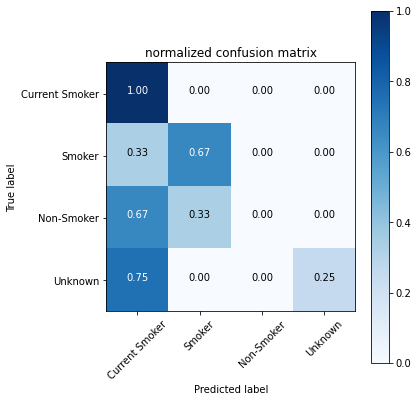

In [101]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


if __name__ == "__main__":
    target_names = [ 'Current Smoker', 'Smoker', 'Non-Smoker', 'Unknown']
    labels = actual
    preds = predictions
    print(classification_report(labels, preds, target_names=target_names))
    print ("**************************************************************")

    plt.figure(figsize=(6,6))
    cnf_matrix = confusion_matrix(labels, preds)
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                        title='normalized confusion matrix')

    plt.show()